In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Model
from tqdm import tqdm
from PIL import Image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
import random

In [3]:
# Set up paths and parameters
base_dir ='training'
img_size = (224, 224)  
batch_size = 32

In [4]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of data for validation
)

In [5]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1659 images belonging to 5 classes.
Found 412 images belonging to 5 classes.


In [6]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [7]:
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [9]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


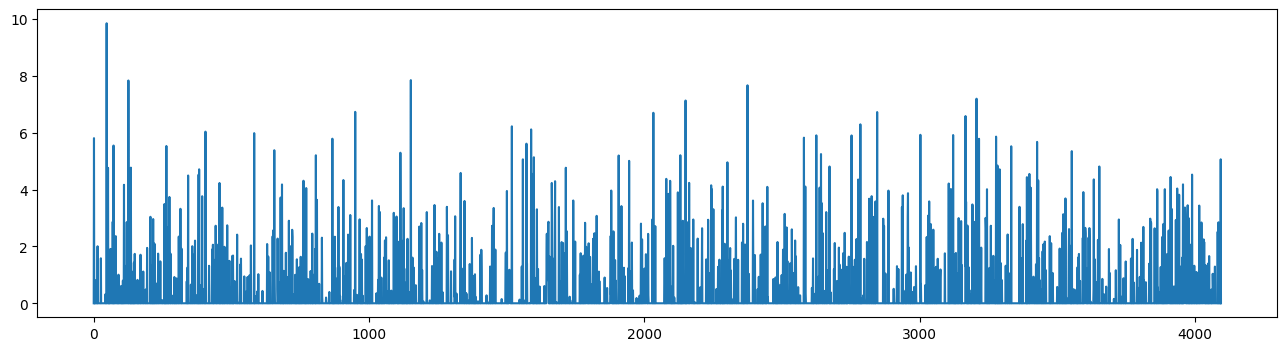

In [10]:
img, x = load_image("training/EARRINGS/CFE0686_D.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [11]:
feat.shape

(1, 4096)

In [12]:
images_path = 'training'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 2000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 2000 images to analyze


In [13]:
features = []
for i, image_path in enumerate(images):
    img, x = load_image(image_path)
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=500)
pca.fit(features)

PCA(n_components=500)

In [15]:
pca_features = pca.transform(features)

In [16]:
from scipy import spatial

In [17]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ spatial.distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

In [18]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

# Let’s try this with a random image from the dataset

Text(0.5, 1.0, 'result images')

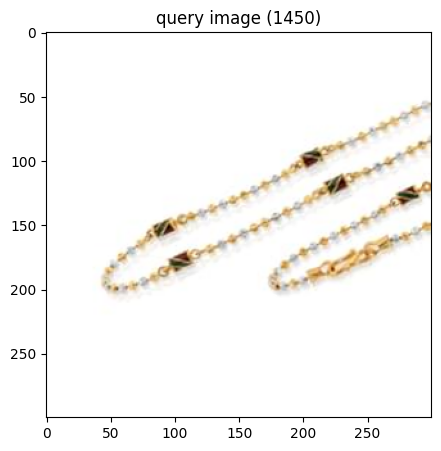

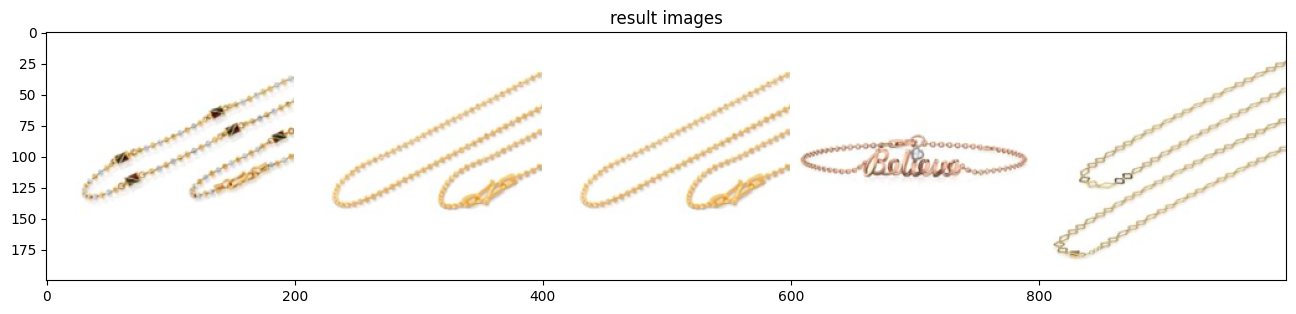

In [19]:
import random
query_image_idx = int(len(images) * random.random()) # do a query on a random image
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

## Try it importing a new image
If we want to analyze a new image that was not included in the original dataset, we can simply extract its feature vector and project it into the PCA space using the saved PCA object.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Text(0.5, 1.0, 'result images')

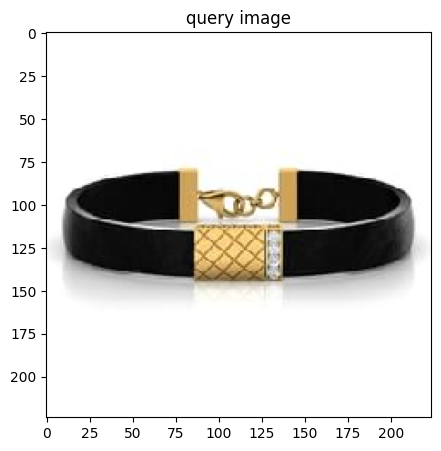

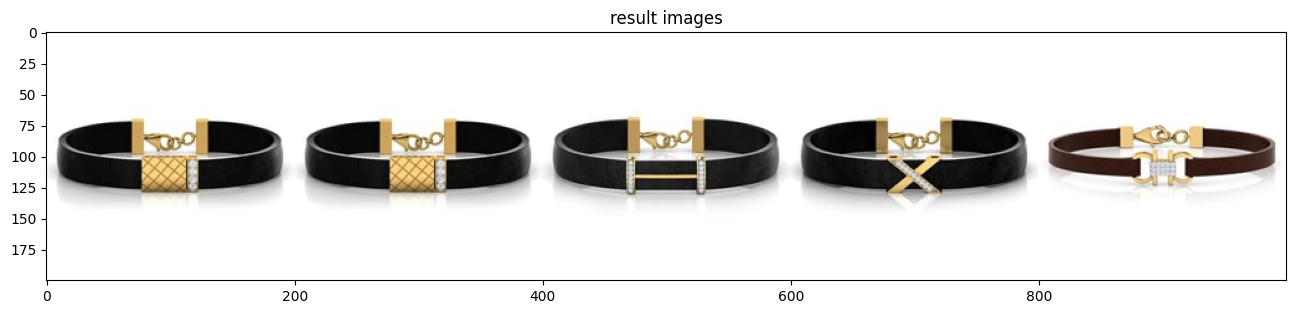

In [20]:
# load image and extract features
new_image, x = load_image("training/BRACELET/bracelet_041.jpg")
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ spatial.distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5]  # grab first 5
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

# Color Feature Extraction Using OpenCV

In [29]:
import cv2

# Function to compute the color histogram for a single image
# Function to compute the color histogram for a single image
def compute_color_histogram(image_path, color_space='LAB', bins=64):
    # Check if file exists
    if not os.path.isfile(image_path):
        print(f"File not found: {image_path}")
        return None
    # Read the image
    image = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
        
    # Convert the image to the desired color space
    if color_space == 'HSV': # Hue ,saturation, value
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB': 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Compute histogram for each channel
    histograms = []
    for channel in range(image.shape[2]):
        hist = cv2.calcHist([image], [channel], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist)  # Normalize the histogram
        histograms.append(hist)

    return histograms

### This function compares the histogram of two images and returns a similarity score

In [22]:
# Function to compare histograms using a similarity metric
def compare_histograms(hist1, hist2, method=cv2.HISTCMP_CHISQR):
    similarity = 0
    for channel in range(len(hist1)):
        # Normalize histograms
        hist1[channel] = cv2.normalize(hist1[channel], hist1[channel]).flatten()
        hist2[channel] = cv2.normalize(hist2[channel], hist2[channel]).flatten()
        
        # Calculate similarity
        score = cv2.compareHist(hist1[channel], hist2[channel], method)
        
        # Check for division by zero
        if score == 0:
            similarity_channel = 1  # or any other default value that makes sense for your use case
        else:
            similarity_channel = 1 / (1 + score)
        
        similarity += similarity_channel
        
    return similarity / len(hist1)

#### This function processes a folder of jewellery images and computes color histograms for each one. The histograms are stored in a dictionary where the image filenames are the keys, and the computed histograms are the values.

In [30]:

# Function to process all images in the dataset
def process_jewellery_dataset(dataset_folder, color_space='LAB', bins=64):
    histograms = {} # it will store the computed histogram  in a dictionary
    # List of valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    # Loop over each image in the dataset
    for image_filename in os.listdir(dataset_folder):
        # Get the file extension
        ext = os.path.splitext(image_filename)[1].lower()
        # Check if it's a valid image file
        if ext in valid_extensions:
            image_path = os.path.join(dataset_folder, image_filename)
            # Compute the histogram for the image
            hist = compute_color_histogram(image_path, color_space=color_space, bins=bins)
            if hist is not None:
                # Store the histogram with the image name
                histograms[image_filename] = hist

    return histograms

In [31]:
# Function to find the most similar images based on color histogram comparison
def find_similar_images(query_image_path, dataset_histograms, color_space='LAB', bins=64, method=cv2.HISTCMP_CHISQR):
    query_hist = compute_color_histogram(query_image_path, color_space, bins)
    similarity_scores = {}
    for image_filename, dataset_hist in dataset_histograms.items():
        score = compare_histograms(query_hist, dataset_hist, method)
        similarity_scores[image_filename] = score
    sorted_images = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_images

In [32]:
def display_similar_images(query_image_path, similar_images, dataset_folder, top_n=5):
    plt.figure(figsize=(15, 15))

    # Display the query image
    query_image = cv2.imread(query_image_path)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

    plt.subplot(1, top_n + 1, 1)
    plt.imshow(query_image)
    plt.title('Query Image')
    plt.axis('off')

    # Display the top N similar images
    for i, (image_filename, score) in enumerate(similar_images[:top_n]):
        image_path = os.path.join(dataset_folder, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, top_n+1, i+2)
        plt.imshow(image)
        plt.title(f'Similarity: {score:.2f}')
        plt.axis('off')

    plt.show()

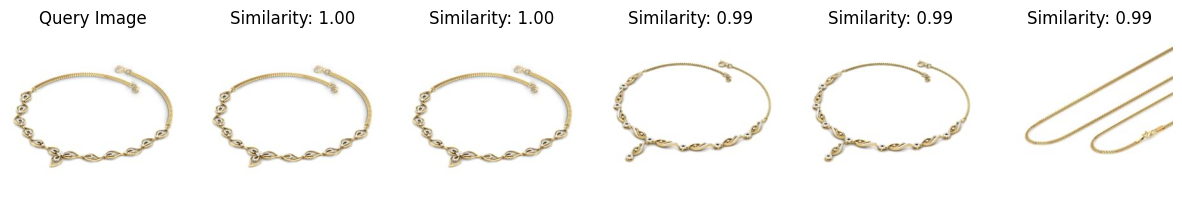

In [34]:
# Example usage with your dataset folder
dataset_folder = 'training/NECKLACE'
query_image_path = 'training/NECKLACE/necklace_10.jpg'

# Preprocess the dataset to compute histograms
dataset_histograms = process_jewellery_dataset(dataset_folder, color_space='LAB', bins=64)

# Find the top 5 most similar images
similar_images = find_similar_images(query_image_path, dataset_histograms, color_space='LAB', bins=64, method=cv2.HISTCMP_CHISQR)

# Display the query image and the most similar images
display_similar_images(query_image_path, similar_images, dataset_folder, top_n=5)
